# Métodos sem malha
Neste exemplo, utilizo o método dos mínimos quadrados móveis para interpolar funções escalares, além de adicionar o método da colocação para resolver equações diferenciais parciais

## Dependências

In [1]:
%matplotlib notebook

import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import pprint as pp

## Dados
dados de exemplo: 
 - interpolação: $z = 2x+y^2-xy$
 
 
 - EDP: $
 \begin{cases}
 \nabla^2u=0\\
 (x,y) \in (0,1)\times(0,1)\\
 x=0\ \text{ou}\ x=1, \dfrac {\partial u} {\partial x} = 0, \text{Condição de Neumann}\\
 y=0, u=0 \quad \text{Condição de Dirichlet}\\
 y=1, u=1 \quad \text{Condição de Dirichlet}
 \end{cases}
 $

In [2]:
#### dados de exemplo para interpolação por mínimos quadrados móveis
interpol_data = [
    [0.5, 0.062408758274352105, 1.0125256662877162],
    [0.447711576862026, 0.7680861842132574, 1.14149846340328],
    [0.6928072377730861, 0.8192031431762375, 1.4891583985370405],
    [0.16791353130182318, 0.36344468640933736, 0.4068918219549523],
    [0.42633701962624004, 0.1423466043933539, 0.8122489679638201],
    [0.3928812775185744, 0.8308615441039886, 1.1496635156193826],
    [0.8774760430204951, 0.6754122773672129, 1.618475737907712],
    [0.11154008787913916, 0.44871554861818586, 0.37437604760438925],
    [0.9753387832461635, 0.19225053054578867, 1.8001284344465054],
    [0.47016443282445786, 0.9384985267007433, 1.3798597227555374],
    [0.9827866235704859, 0.020709609407733476, 1.9456490079575026],
    [0.6342449242584626, 0.9146502818399507, 1.5249626878582656],
    [0.9966107320409124, 0.780033531403195, 1.8242839854469677],
    [0.34042822889549673, 0.4758376538526644, 0.7452893608721505],
    [0.781028820398589, 0.6373060739643224, 1.4704622615277858],
    [0.7915660098236119, 0.19259682552009116, 1.4677724561660073],
    [0.3011828746881986, 0.8125033388889318, 1.0178153337817315],
    [0.13635614275310148, 0.07406366364688477, 0.2680986762859495]
]
interpol_base = ["1","x","x**2","y","y**2","x*y"]; #Base quadrática

# dados de exemplo para solução de E.D.P utilizando método da colocação
k=8
pde_domain_count = (k-1)**2
pde_contour_count = 8

pde_data = [[x/k,y/k] for x in range(1,k) for y in range(1,k)]+[
    [0,0],
    [0,1],
    [1,0],
    [1,1],
    [1,.5],
    [.5,0],
    [0,.5],
    [.5,1]
]

# polynomial base
pde_base = ["1","x","x**2","y","y**2","x*y"]
pde_base_x = ["0","1","2*x","0","0", "y"]
pde_base_xx = ["0","0","2","0","0","0"]
pde_base_y = ["0","0","0","1","2*y","x"]
pde_base_yy =  ["0","0","0","0","2","0"]

# linear base
#pde_base = ["1","x","y"]
#pde_base_x = ["0","1","0"]
#pde_base_xx = ["0","0","0"]
#pde_base_y = ["0","0","1"]
#pde_base_yy =  ["0","0","0"]

pde_differential_x = {
    'order': 2,
    'var': 'x',
    'base1': pde_base_x,
    'base2': pde_base_xx
}
pde_differential_y = {
    'order': 2,
    'var': 'y',
    'base1': pde_base_y,
    'base2':pde_base_yy
}


# Crio um objeto com as condições de contorno
pde_contour_conditions = {
    'top': {
        'kind': 'dirichlet',
        'value': 0
    },
    'bottom':{
        'kind': 'dirichlet',
        'value': 0
    },
    'left':{       
        'kind': 'neumann',
        'order': 1,
        'var': 'x',
        'base1': pde_base_x,
        'base2': pde_base_xx,
        'value': 0
    },
    'right':{
        'kind': 'neumann',
        'order': 1,
        'var': 'x',
        'base1': pde_base_x,
        'base2': pde_base_xx,
        'value': 0
    }
}

def pde_contour_func(p): #p é o parâmetro que caracteriza aonde está o contorno
    clazz = pde_contour_class(p)
    cond = pde_contour_conditions[clazz]
    if cond['kind']=='dirichlet':
        return cond['value']
    elif cond['kind']=='neumann':
        return cond['value']
    print(clazz)

def pde_domain_func(p):
    return np.exp(-((p[0]-.5)*(p[0]-.5) + (p[1]-.5)*(p[1]-.5))) #retorna f(x) que é a função no domínio

def pde_func(p):
    clazz = pde_contour_class(p)
    if clazz:
        return pde_contour_func(p)
    else:
        return pde_domain_func(p)

def pde_contour_class(r): # É a classe da minha condição de contorno, (r(0)= x, r(1)= y), que é similar ao p
    if r[1]==0:
        return 'bottom'
    elif r[1]==1:
        return 'top'
    elif r[0]==0:
        return 'left'
    elif r[0]==1:
        return 'right'
    else:
        return None

## Gaussiana com raio
Função gaussiana com raio, interpola suavemente de 0 a r centrada na origem.

$$
w(\vec d) = 
\begin{cases}
\dfrac{{e^{-({\frac{||\vec d||}c})^2}} - {e^{-({\frac r c})^2}}}{1-{e^{-({\frac{r}c})^2}}}, d<r
\\\\
0, d > r
\end{cases}
$$

Parâmetros:
 - `dist`: $\vec d$
 - `r`: raio limite onde a função $G(\vec d) \rightarrow 0$

<IPython.core.display.Javascript object>


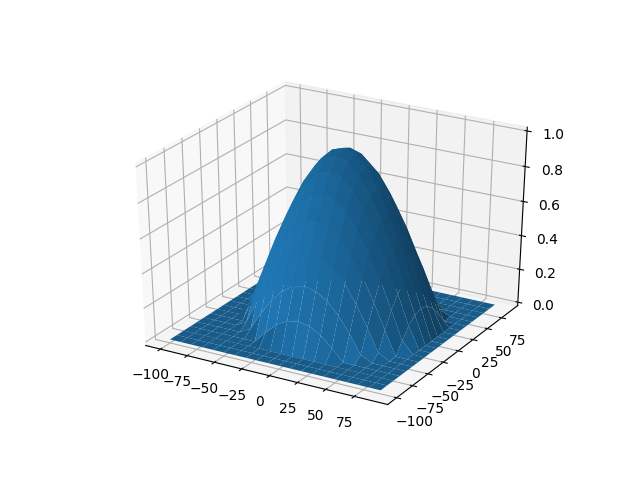

<IPython.core.display.Javascript object>


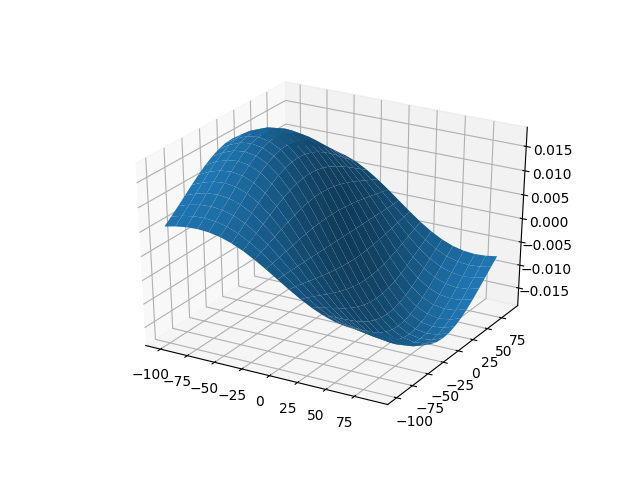

<IPython.core.display.Javascript object>


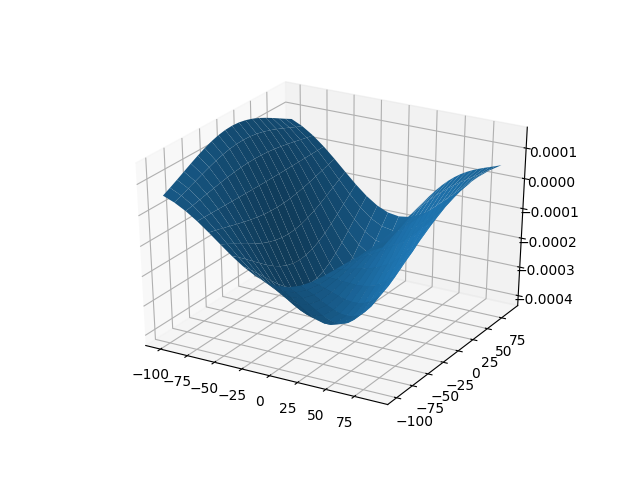

In [3]:
def gaussian_with_radius(dist,r,derivate=None):
    c=100
    exp1 = np.exp(-(la.norm(dist)/c)**2)
    exp2 = np.exp(-(r/c)**2)
    weight = ( exp1 - exp2 )/(1-exp2)
    if not derivate:
        return weight if (la.norm(dist) <=r) else 0
    else:
        c1 = 1/(1-exp2)
        c2 = exp1/(1-exp2) #ACHO QUE É EXP2
        
        if derivate['var']=='x':
            axis = dist[0]
        elif derivate['var']=='y':
            axis = dist[1]

        # primeira derivada
        d1 = -2*c1*exp1*axis/(c**2)
        # segunda derivada
        d2 = -2*c1*(c**2 - 2*axis**2)*exp1/(c**4)
        return d1 if derivate['order']==1 else d2

fig = plt.figure("peso -gaussiana com raio")
xs = np.arange(-100,100,10)
ys = np.arange(-100,100,10)
X, Y = np.meshgrid(xs, ys)

zs = np.array([ gaussian_with_radius([x,y],80) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z=zs.reshape(X.shape)


mesh_plot = fig.add_subplot(111, projection='3d')
mesh_plot.plot_surface(X,Y,Z)

fig = plt.figure("peso -gaussiana com raio - primeira derivada")
xs = np.arange(-100,100,10)
ys = np.arange(-100,100,10)
X, Y = np.meshgrid(xs, ys)

zs = np.array([ gaussian_with_radius([x,y],80,{'order': 1,'var': 'x'}) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z=zs.reshape(X.shape)


mesh_plot = fig.add_subplot(111, projection='3d')
mesh_plot.plot_surface(X,Y,Z)

fig = plt.figure("peso -gaussiana com raio - segunda derivada")
xs = np.arange(-100,100,10)
ys = np.arange(-100,100,10)
X, Y = np.meshgrid(xs, ys)

zs = np.array([ gaussian_with_radius([x,y],80,{'order': 2,'var': 'x'}) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z=zs.reshape(X.shape)


mesh_plot = fig.add_subplot(111, projection='3d')
mesh_plot.plot_surface(X,Y,Z)

## Pesos $W$

In [4]:
def W(data,point,r,derivate = None):
    W=[]
    if not derivate:
        for index,row in enumerate(data):
            d2d = row[0:2] # (x,y)
            leftZeroes = np.zeros([1,index]) # 0 0 0 ... 0 } index vezes
            rightZeroes = np.zeros([1,len(data) - index - 1])
            weight = gaussian_with_radius(np.subtract(d2d,point),r)
            newRow = np.concatenate([leftZeroes,[[weight]],rightZeroes],axis=1)[0]
            W.append(newRow)
        return W
    else:
        for index,row in enumerate(data):
            d2d = row[0:2]
            leftZeroes = np.zeros([1,index])
            rightZeroes = np.zeros([1,len(data) - index - 1])
            weight = gaussian_with_radius(np.subtract(d2d,point),r,derivate)
            newRow = np.concatenate([leftZeroes,[[weight]],rightZeroes],axis=1)[0]
            W.append(newRow)
        return W

## Matriz de Base $P$

In [5]:
def create_base(base,data):
    P=[]
    for dat in data:
        row = []
        for b in base:
            #exec("x=%s"%dat[0])
            #exec("y=%s"%dat[1])
            [x,y] = dat[0:2]
            row.append(eval(b))
        P.append(row)
    return P

## Valor de m ideal

In [6]:
def ideal(data,base,point,r):
    n = len(data)
    P = create_base(base,data)
    maximumP = np.matrix(P).max()
    minimum = maximumP*10**-15
    smaller = W(data,point,r)[np.where(W(data,point,r) < minimum)]
    nz = len(np.transpose(smaller[0])) #numero de valores menores do que o minimo em W
    dz = (nz/n)*100
    return dz

## Coeficientes $\varphi_k(x)$
Coeficientes utilizados na interpolação linear
$$
\begin{aligned}
B(x) &= P^TW(x)\\
A(x) &= B(x)P = P^TW(x)P\\
\varphi^T(x)&=p^TA^{-1}(x)B(x)
\end{aligned}
$$

In [7]:
def coefficients(data,point,base,derivate=None):
    m = len(pde_base)
    r = get_radius(data,point,m)
    P = create_base(base,data)
    Pt = np.transpose(P)
    pt = create_base(base,[point])
   # ide = ideal(data,base,point,r)
    
    while True:
        B = Pt@W(data,point,r)
        A = B@P
        det = la.det(A)
        if(abs(det) < 1e-3):
            r*=1.1;
           # print(ide(data,base,point,r))
            continue
        if not derivate:
            return pt@la.inv(A)@B
        else:
            dptd_ = create_base(derivate['base1'],[point])
            d2ptd_2= create_base(derivate['base2'],[point])
            dWd_ = W(data,point,r,{
                'order': 1,
                'var': derivate['var']
            })
            dAd_ = Pt@dWd_@P
            dBd_ = Pt@dWd_
            invA = la.inv(A)
            d2Wd_2 = W(data,point,r,{
                'order': 2,
                'var': derivate['var']
            })
            d2Bd_2=Pt@d2Wd_2
            d2Ad_2 = Pt@d2Wd_2@P

            # primeira derivada
            d1 = dptd_@invA@B - pt@invA@dAd_@invA@B + pt@invA@dBd_

            # segunda derivada
            d2 = d2ptd_2@invA@B - 2*dptd_@invA@dAd_@invA@B + 2*dptd_@invA@dBd_ + 2*pt@invA@dAd_@invA@dAd_@invA@B - 2*pt@invA@dAd_@invA@dBd_ - pt@invA@d2Ad_2@invA@B + pt@invA@d2Bd_2

            if derivate['order']==1:
                return d1
            elif derivate['order']==2:
                return d2
        break

## Raio mínimo $R$
parâmetros:
 - `data`: conjunto de dados
 - `points`: pontos de referência
 - `m`: quantidade de pontos no suporte

In [8]:
def get_radius(data,point,m):
    distances = []
    for dat in data:
        dif = np.subtract(point,dat[0:2])
        dist = la.norm(dif)
        distances.append(dist)
    distances = sorted(distances);
    return distances[m+1]

## Função de interpolação $ũ$

In [9]:
def interpol(data,base,point):
    c  = coefficients(data,point,base)
    u=np.array([z for x,y,z  in data])

    return np.matmul(c,u);


## Teste de interpolação

<IPython.core.display.Javascript object>


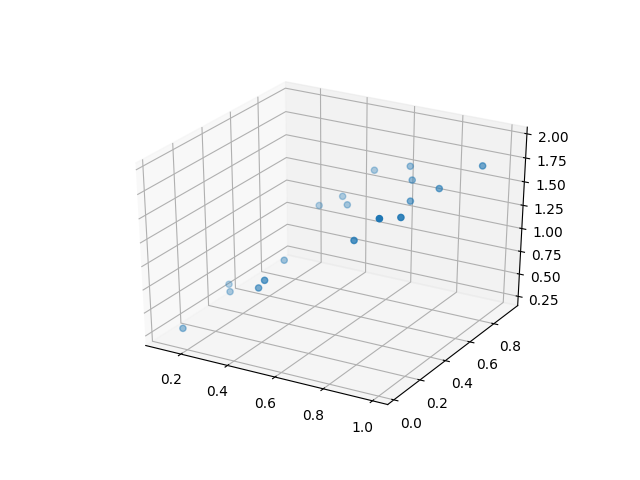

<IPython.core.display.Javascript object>


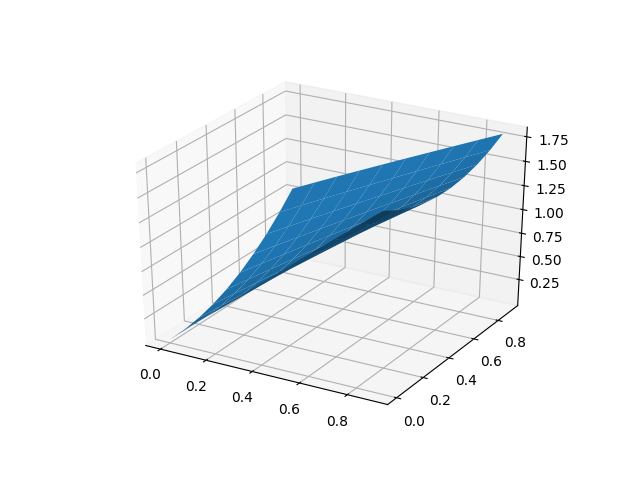

In [10]:
xs = [x for x,y,z in interpol_data]
ys = [y for x,y,z in interpol_data]
zs = [z for x,y,z in interpol_data]

fig = plt.figure("interpol - dados")

data_plot = fig.add_subplot(111, projection='3d')
data_plot.scatter(xs,ys,zs)

fig = plt.figure("interpol -aproximação")
xs = np.arange(0,1,0.1)
ys = np.arange(0,1,0.1)
X, Y = np.meshgrid(xs, ys)

zs = np.array([ interpol(interpol_data,interpol_base,[x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z=zs.reshape(X.shape)

mesh_plot = fig.add_subplot(111, projection='3d')
mesh_plot.plot_surface(X,Y,Z)

## Método da colocação
Sejam $x_1 \dots x_n$ $n$ pontos no domínio sujeitos a equação $\mathcal L u(x) = b(x)$ e $x_{n+1} \dots x_{n+m}$ $m$ pontos no contorno sujeitos as equações $\mathcal L_k c(x) = b_k(x)$


$$
\begin{aligned}
(\mathcal L \varphi)&*&\mathbf u &= &\mathbf b\\
\left[
\begin{matrix}
\mathcal L \varphi_1(x_1) & \dots & \mathcal L \varphi_n(x_1)& 0 &\dots & 0 \\
&\vdots&&&\vdots\\
\mathcal L \varphi_1(x_n)& \dots & \mathcal L \varphi_n(x_n) & 0 &\dots & 0 \\
0 & \dots & 0 &\mathcal L_1 c_1(x_{n+1})&\dots & \mathcal L_1 c_m(x_{n+1})\\
&\vdots&&&\vdots \\
0 & \dots & 0 &\mathcal L_m c_1(x_{n+m})&\dots & \mathcal L_m c_m(x_{n+m})
\end{matrix}
\right]&*
&\left[
\begin{matrix}
u_1\\ \vdots \\ u_n\\ u_{n+1} \\ \vdots \\ u_{n+m}
\end{matrix}
\right] &=
&\left[
\begin{matrix}
b(x_1) \\ \vdots \\ b(x_n) \\ b_1(x_{n+1}) \\ \vdots \\ b_m(x_{n+m})
\end{matrix}
\right]
\end{aligned}
$$

<IPython.core.display.Javascript object>


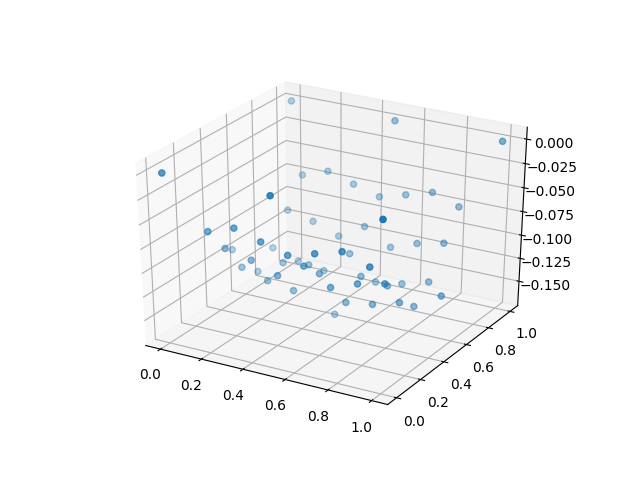

<IPython.core.display.Javascript object>


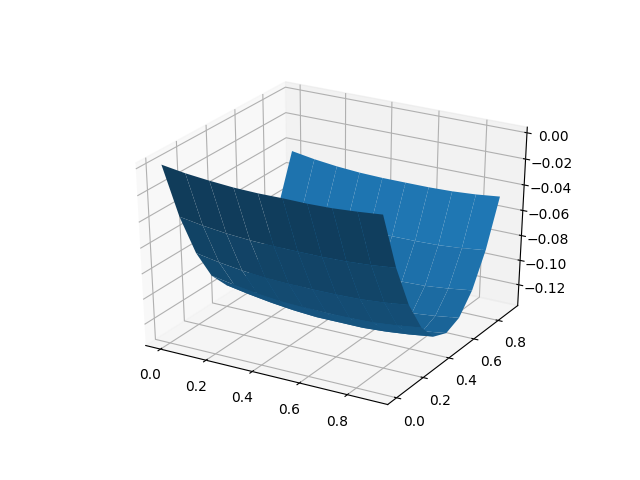

[[ 0.00140266 -0.00130688 -0.00307558 -0.0044035  -0.00489758 -0.00472197
  -0.00489758 -0.0044035  -0.00307558 -0.00130688]
 [-0.04431187 -0.04726526 -0.04935157 -0.05065964 -0.05121563 -0.05123977
  -0.05121563 -0.05065964 -0.04935157 -0.04726526]
 [-0.0795289  -0.0827999  -0.08523534 -0.08681399 -0.08743014 -0.08756337
  -0.08743014 -0.08681399 -0.08523534 -0.0827999 ]
 [-0.10474849 -0.10799964 -0.11070566 -0.11270732 -0.11338513 -0.11362108
  -0.11338513 -0.11270732 -0.11070566 -0.10799964]
 [-0.11957757 -0.12289062 -0.1256568  -0.12772013 -0.12898693 -0.12896012
  -0.12898693 -0.12772013 -0.1256568  -0.12289062]
 [-0.1241803  -0.12769309 -0.13056837 -0.13273441 -0.13373846 -0.13439662
  -0.13373846 -0.13273441 -0.13056837 -0.12769309]
 [-0.11957757 -0.12289062 -0.1256568  -0.12772013 -0.12898693 -0.12896012
  -0.12898693 -0.12772013 -0.1256568  -0.12289062]
 [-0.10474849 -0.10799964 -0.11070566 -0.11270732 -0.11338513 -0.11362108
  -0.11338513 -0.11270732 -0.11070566 -0.10799964]


In [12]:

lphi = []
for i in range(pde_domain_count+pde_contour_count):
    point = pde_data[i]
    if i < pde_domain_count:
        cx  = coefficients(pde_data,point,pde_base,pde_differential_x)    
        cy  = coefficients(pde_data,point,pde_base,pde_differential_y)    
        
        result = np.add(cx[0],cy[0])
        lphi.append(result);
    else:
        clazz = pde_contour_class(point)
        cond = pde_contour_conditions[clazz]
        if cond['kind'] == 'dirichlet':
            c  = coefficients(pde_data[pde_domain_count:],point,pde_base)
            lphi.append(np.append(np.zeros(pde_domain_count),c[0]))
        elif cond['kind'] == 'neumann':
            c  = coefficients(pde_data,point,pde_base,cond)
            lphi.append(c[0])


bb = [pde_func(p) for p in pde_data]
answer = la.inv(lphi)@bb

xs = [x for x,y in pde_data]
ys = [y for x,y in pde_data]
zs = answer

fig = plt.figure("pde - dados")

data_plot = fig.add_subplot(111, projection='3d')
data_plot.scatter(xs,ys,zs)


fig = plt.figure("pde - aproximação")
xs = np.arange(0,1,0.1)
ys = np.arange(0,1,0.1)
X, Y = np.meshgrid(xs, ys)

cat_data = np.concatenate((np.array(pde_data),np.transpose([answer])),axis=1)
zs = np.array([ interpol(cat_data,pde_base,[x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z=zs.reshape(X.shape)

print(Z)

mesh_plot = fig.add_subplot(111, projection='3d')
mesh_plot.plot_surface(X,Y,Z)